## Word Vectors Game of Thrones

In [15]:
import codecs                         # for encoding words
import glob                           # import regular expression 
import re                             # regular expression as well
import nltk                           # nltk for language process
import gensim.models.word2vec as w2v 
import gensim
import numpy as np
import sklearn.manifold               # visualize high dimentions data 
import multiprocessing 
import os               
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/huang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [16]:
## download nltk data 
nltk.download('punkt')        # pretrained tokenizer
nltk.download('stopwords')    

[nltk_data] Downloading package punkt to /Users/huang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/huang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 1. Prepare raw data 

In [17]:
# get the book names, matching text file 
book_filenames = sorted(glob.glob('data/*.txt'))  ## read all txt files in data folder
print("Found books:")
book_filenames

Found books:


['data/got1.txt',
 'data/got2.txt',
 'data/got3.txt',
 'data/got4.txt',
 'data/got5.txt']

In [18]:
## read data into memeory 
corpus_raw = ""
for book_filename in book_filenames:
    with open(book_filename) as f:
        corpus_raw += f.read()
    print("Finish text {}, Corpus is now {} characters long".format(book_filename,len(corpus_raw)))

Finish text data/got1.txt, Corpus is now 1770659 characters long
Finish text data/got2.txt, Corpus is now 4071041 characters long
Finish text data/got3.txt, Corpus is now 6391405 characters long
Finish text data/got4.txt, Corpus is now 8107945 characters long
Finish text data/got5.txt, Corpus is now 9719485 characters long


##### Split the corpus into sentences and tokenize all of them

In [19]:
from nltk.tokenize import sent_tokenize, word_tokenize  # import tokenizer 

In [20]:
raw_sentences = sent_tokenize(corpus_raw)  #split raw text into sentances 

In [21]:
## word tokenize each word in each sentence 
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)  # ^ mean not equal to, so this will get ride of everything but letters
    words = clean.split()                 # split out each word 
    return words

#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
        
len(sentences)

128868

### 2. Train Word2Vec

In [22]:
num_features = 300   ## number of dimentions we allow it to have, it is essentiall number of features
min_word_count = 3    ## Minimum word count threshold, it will ignore words less then min_word_count, just to clear noise
context_size = 7     ## block of 7 window at a time 
downsampling = 1e-3  ## downsampling for frequent word, 
seed = 1             ## for random number generator 
num_workers = multiprocessing.cpu_count()  ## number of process we want to run in parellel

In [23]:
# train the word2vec model 
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [24]:
thrones2vec.build_vocab(sentences)

In [25]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17277


### train the model 

In [26]:
corpus_count = thrones2vec.corpus_count
iteration = thrones2vec.iter
if gensim.__version__[0] == '1':
    thrones2vec.train(sentences)
else:
    thrones2vec.train(sentences,total_examples= corpus_count, epochs= iteration)

### Load trained model and take a look 

In [27]:
## save trained model 
if not os.path.exists("trained"):
    os.makedirs("trained")
    thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))
else:
    thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

In [28]:
## visualize you data using tsne
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = thrones2vec.wv.syn0                              ## export the embeding matrix 
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)   ## fit the embeding into tsne model

- plot it 

In [37]:
data =[
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
      ]

points = pd.DataFrame(data,columns=["word", "x", "y"])

In [38]:
points.head()  ### numbers seems to be too big

,word,x,y
0,This,-3.541325e+06,5.889688e+06
1,edition,-7.207983e+06,4.351026e+06
2,the,-7.893905e+06,2.020854e+07
3,complete,-7.862531e+06,1.170385e+07
4,of,6.284213e+07,8.099464e+06


In [86]:
points[['x','y']] = points[['x','y']]/1000000   ## shinks them by 1000000 times 

In [87]:
points.head()

,word,x,y
0,This,-3.541325,5.889688
1,edition,-7.207983,4.351026
2,the,-7.893905,20.208544
3,complete,-7.862531,11.703853
4,of,62.842134,8.099464


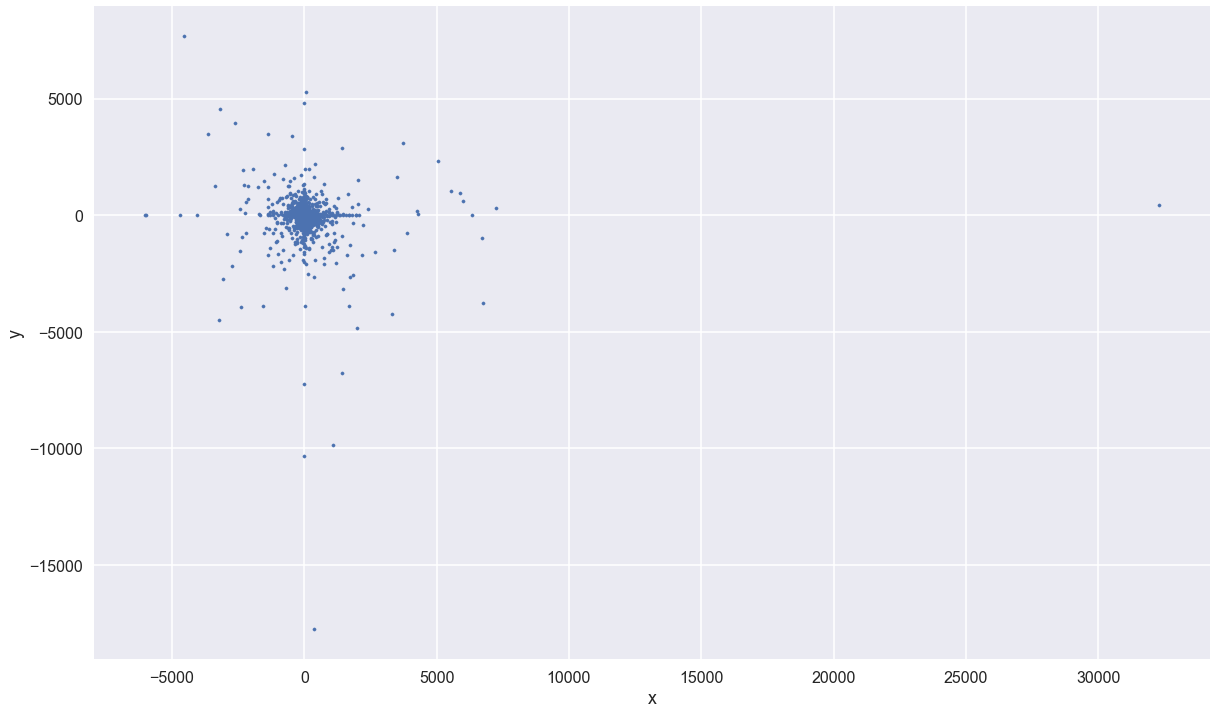

In [88]:
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [107]:
## zoom in 
def plot_region(x_bounds, y_bounds):
    slice = points[
        (points.x >= x_bounds[0]) &
        (points.x <= x_bounds[1]) & 
        (points.y >= y_bounds[0]) &
        (points.y <= y_bounds[1])
    ]
    ax = slice.plot.scatter("x", "y", s=20, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

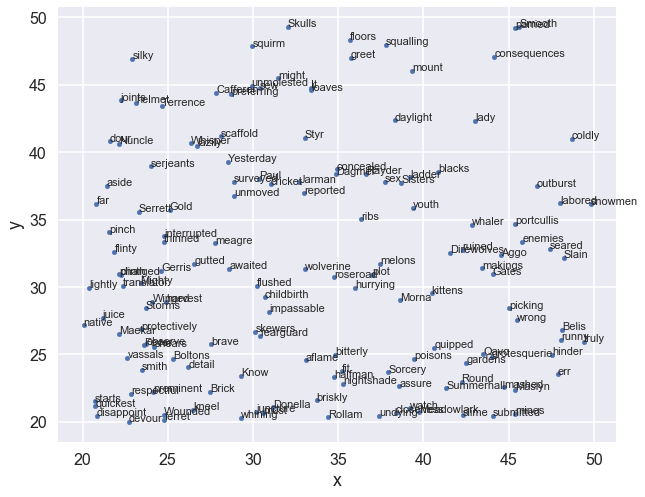

In [108]:
plot_region(x_bounds=(20, 50), y_bounds=(20, 50))